#**Dataset multiclase de reseñas sobre establecimientos de restauración**

##1. Contexto

La restauración es uno de los sectores más importantes de España. Aportando el 4,9% del VAB (Valor Añadido Bruto), unos **67 mil millones de euros** y un 6,4% del empleo integrando a más de **1,3 millones de trabajadores**. Además, las empresas del sector representan el 8% del tejido empresarial nacional, superando a los demás países de la UE, solo por detrás de Grecia.

**León** encabeza el ranking de las ciudades con más bares por habitante alcanzando los **5,03 bares por cada 1000 habitantes**, seguido de Salamanca y Zamora con 4,22 y 4,14 respectivamente.

Y a pesar de ser un sector tradicional genera una gran cantidad de datos. Entre ellos, las reseñas publicadas por los clientes.

Según un informe publicado en enero de 2024, en el que se analizaron datos de 17000 restaurantes, **el número de reseñas aumentó un 23% en un año**, sumando 16 millones entre todos los locales. Cifrando la media anual de valoraciones recibidas por negocio en 174 y la **nota media del sector en 4,24/5**.




##2. Reseñas reales

¿Por qué no utilizar datos reales?

Desde el inicio quise trabajar con reseñas: preprocesarlas, visualizarlas y probar distintos algoritmos y modelos de NLP. Sin embargo, los conjuntos de datos disponibles resultaban demasiado conocidos y repetitivos. La mayoría se basan en el comercio electrónico y buscaba algo diferente, más cercano.

El problema es que, aunque muchas reseñas son accesibles en la web, no pertenecen al dominio público. Que un contenido sea visible no implica que pueda reutilizarse libremente con fines de recopilación, redistribución o entrenamiento de modelos.

Por este motivo, y para evitar problemas legales y éticos asociados al scraping, opté por generar mi propio dataset sintético, diseñado para reproducir patrones realistas de reseñas sin utilizar datos de personas ni negocios reales.



##3. Construcción del dataset

Para la generación de las reseñas probé los LLMs **GPT-5** y **Gemini 3** con los siguientes promts:

*"Vas a generar reseñas sintéticas de clientes para negocios locales. Las reseñas deben ser completamente ficticias sin basarse en ninguna reseña de comercio real. Debes darme reseñas a medida que te las vaya pidiendo, te especificaré los datos más importantes."*

*"Redacta {número} reseñas en formato csv (negocio, texto, estrellas, tono) que pueda copiar directamente para:*

*Negocio: {negocio}*
*Estrellas: {número de estrellas}*
*Estilo: {estilo}"*












Tras revisar varios ejemplos escogí **Gemini 3** porque genera resultados más realistas, naturales, con expresiones y vocabulario más variado.

##4. Atributos

In [ ]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Synthetic_Reviews/dataset.txt'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(path, encoding = 'utf-8', sep='\t')

###4.1 negocio

Representa el tipo de local al que hace referencia la reseña. Este puede tomar diferentes valores (todos representativos del sector nacional de la restauración):






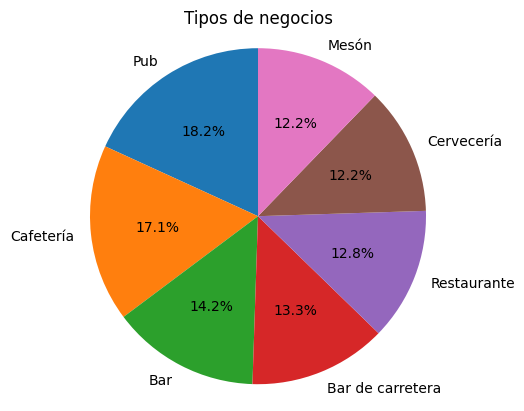

In [ ]:
labels = ['Pub', 'Cafetería', 'Bar', 'Bar de carretera', 'Restaurante', 'Cervecería', 'Mesón']
counts = df['negocio'].value_counts()
sizes = []
for count_val in counts.values:
  size = (count_val / counts.sum())*100
  sizes.append(size)

plt.pie(sizes,
        labels = labels,
        autopct = '%1.1f%%',
        startangle = 90)
plt.axis('equal')
plt.title('Tipos de negocios')
plt.show()

###4.2 texto

Todas las reseñas del dataset cuentan con un texto en el que el cliente describe su experiencia. Contiene valores muy variados marcados por el resto de atributos.

#### 4.2.1 Distribución de la longitud de los textos:

Text(0.5, 0, 'Número de palabras')

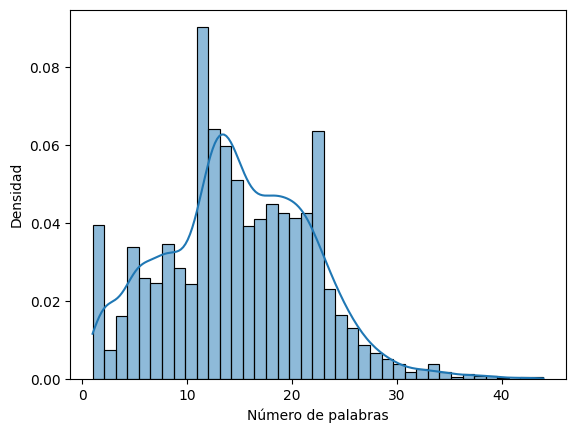

In [ ]:
longitudes = df['texto'].str.split().str.len()
sns.histplot(longitudes, kde=True, stat='density')
plt.ylabel('Densidad')
plt.xlabel('Número de palabras')

###4.3 estrellas

Las valoraciones de los clientes se expresan numéricamente, de 1 a 5 y sin incluir decimales, como sucede en la mayoría de plataformas de reseñas online.

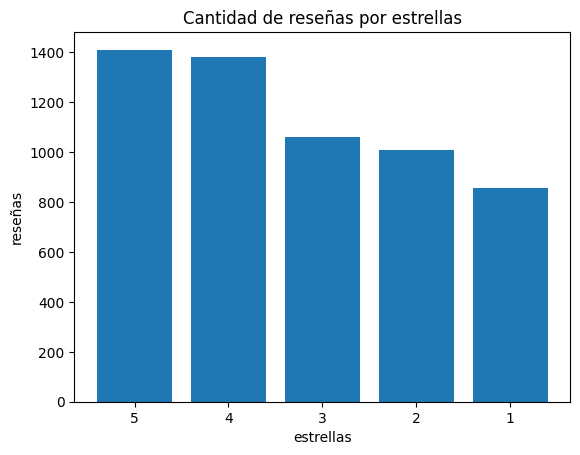

In [ ]:
labels = ['5', '4', '3', '2', '1']
counts = df['estrellas'].value_counts()
sizes = []

for count_val in counts.values:
  sizes.append(count_val)

plt.bar(x = labels,
        height = sizes)
plt.xlabel('estrellas')
plt.ylabel('reseñas')
plt.title('Cantidad de reseñas por estrellas')
plt.show()



####4.3.1 Valoración media del conjunto de datos:

In [ ]:
df['estrellas'].mean()

np.float64(3.25962211336599)

####4.3.2 Palabras más comunes según el número de estrellas:

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se define la función encargada de recopilar las palabras más comunes para x estrellas:

In [ ]:
def get_top_keywords_by_stars(df, star_value, n=20):
  text_corpus = ' '.join(df[df['estrellas'] == star_value]['texto'].str.lower())

  keywords = [word for word in text_corpus.split() if word not in stop_words]

  counts = Counter(keywords)

  return pd.DataFrame(counts.most_common(n), columns = ['Palabra clave', 'Frecuencia'])


La siguiente función muestra por pantalla los gráficos de barras:

In [ ]:
def show_barplots(dfs, titles, palettes):
  fig, axes = plt.subplots(2, 3, figsize=(20, 12))

  axes = axes.flatten()

  for i in range(len(dfs)):
      sns.barplot(
          x='Frecuencia',
          y='Palabra clave',
          data= dfs[i],
          ax=axes[i],
          hue='Palabra clave',
          legend=False,
          palette=palettes[i]
      )
      axes[i].set_title(titles[i], fontsize=15)

  axes[5].axis('off')

  plt.tight_layout()
  plt.show()

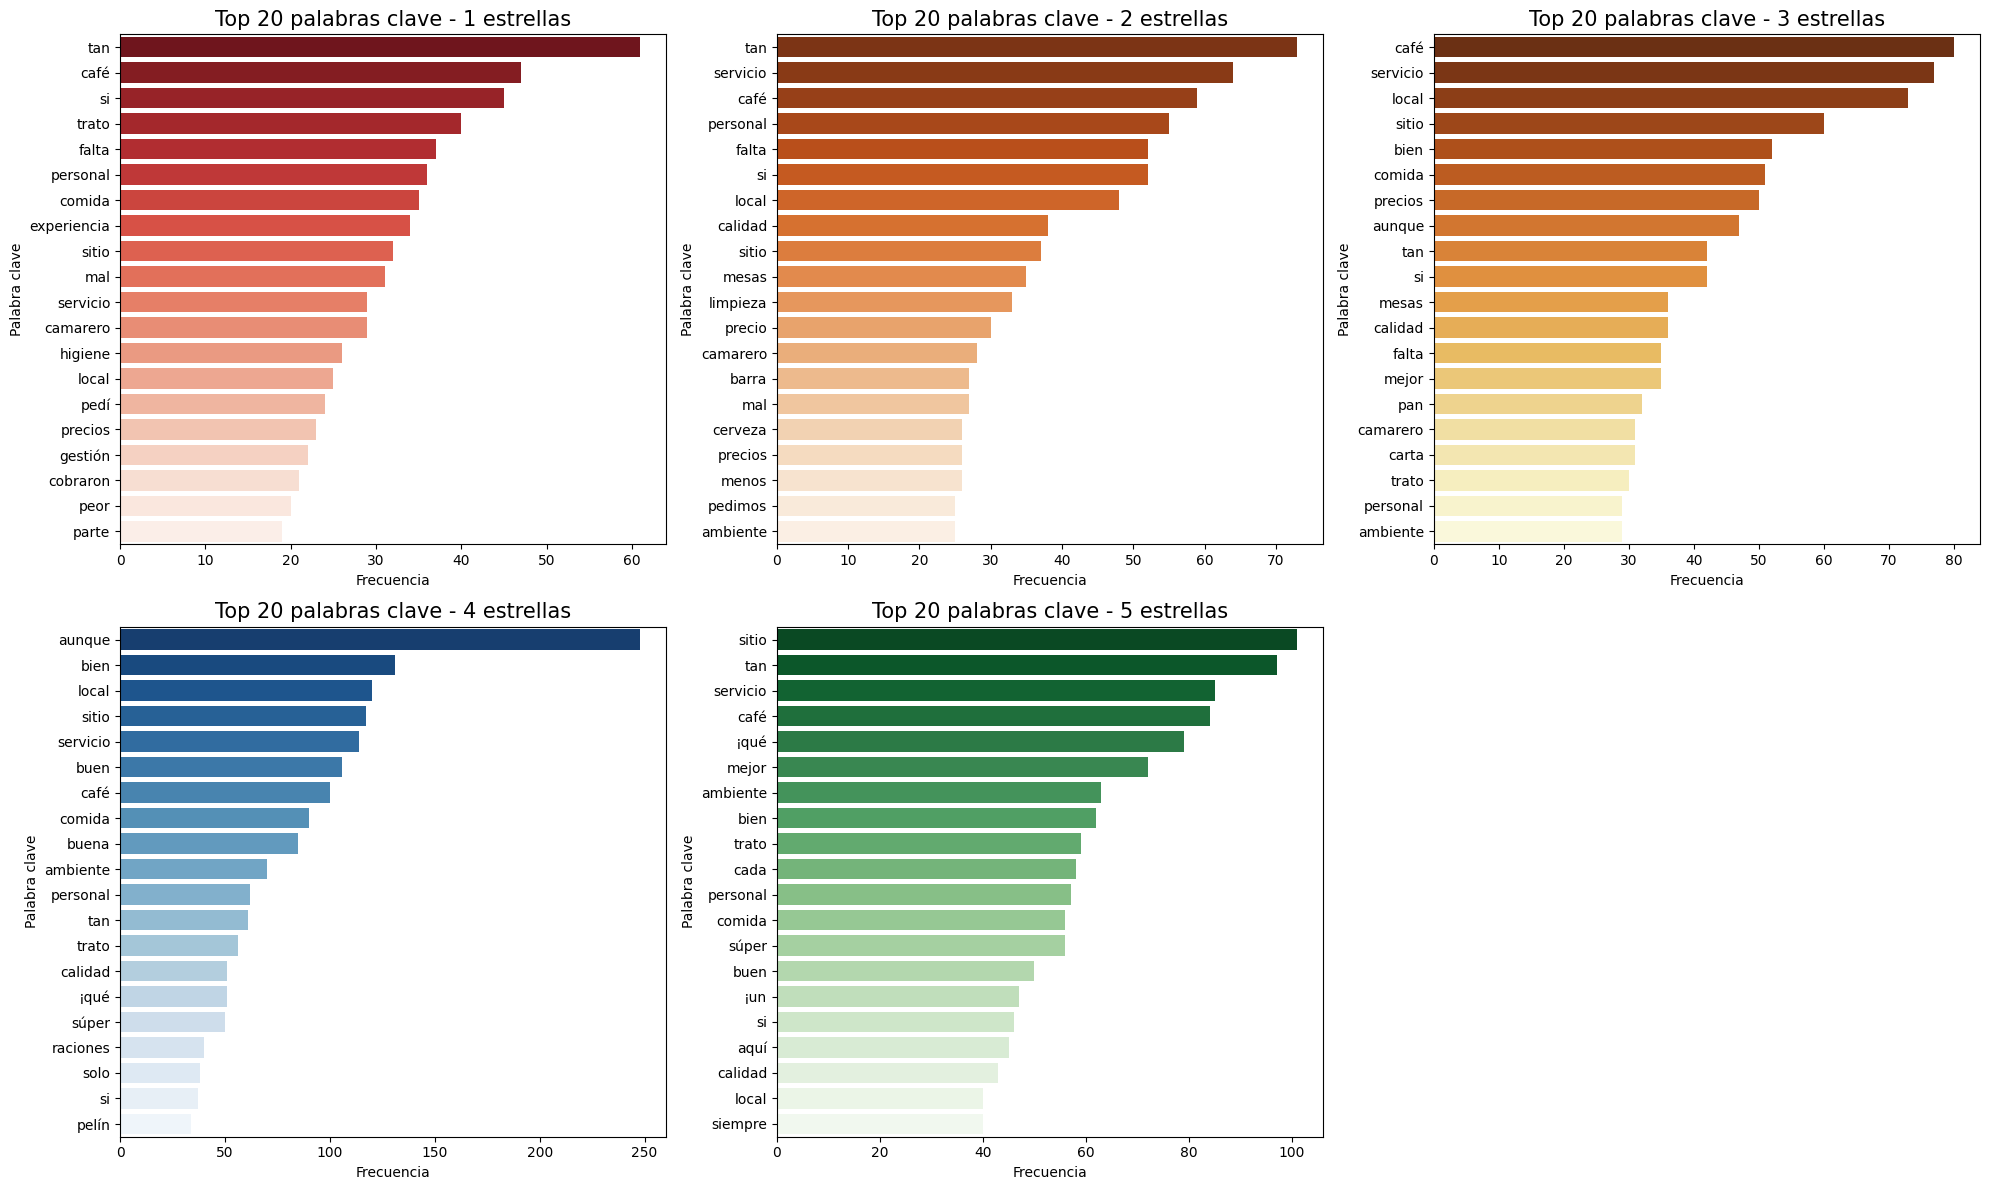

In [ ]:
dfs = []
titles = []
palettes = ['Reds_r', 'Oranges_r', 'YlOrBr_r', 'Blues_r', 'Greens_r']

for i in range(1,6):
  dfs.append(get_top_keywords_by_stars(df, star_value = i))
  titles.append(f'Top 20 palabras clave - {i} estrellas')

show_barplots(dfs, titles, palettes)

####4.3.3 Bigramas más comunes según el número de estrellas:

Función encargada de recopilar los n-gramas más comunes:

In [ ]:
def get_top_ngrams_by_stars(df, star_value, n_gram_size = 2, n=20):
  text_corpus = ' '.join(df[df['estrellas'] == star_value]['texto'].str.lower())
  keywords = [word for word in text_corpus.split() if word not in stop_words]

  n_grams_list = list(ngrams(keywords, n_gram_size))

  n_grams_strings = [" ".join(gram) for gram in n_grams_list]

  counts = Counter(n_grams_strings)
  return pd.DataFrame(counts.most_common(n), columns = ['Palabra clave', 'Frecuencia'])


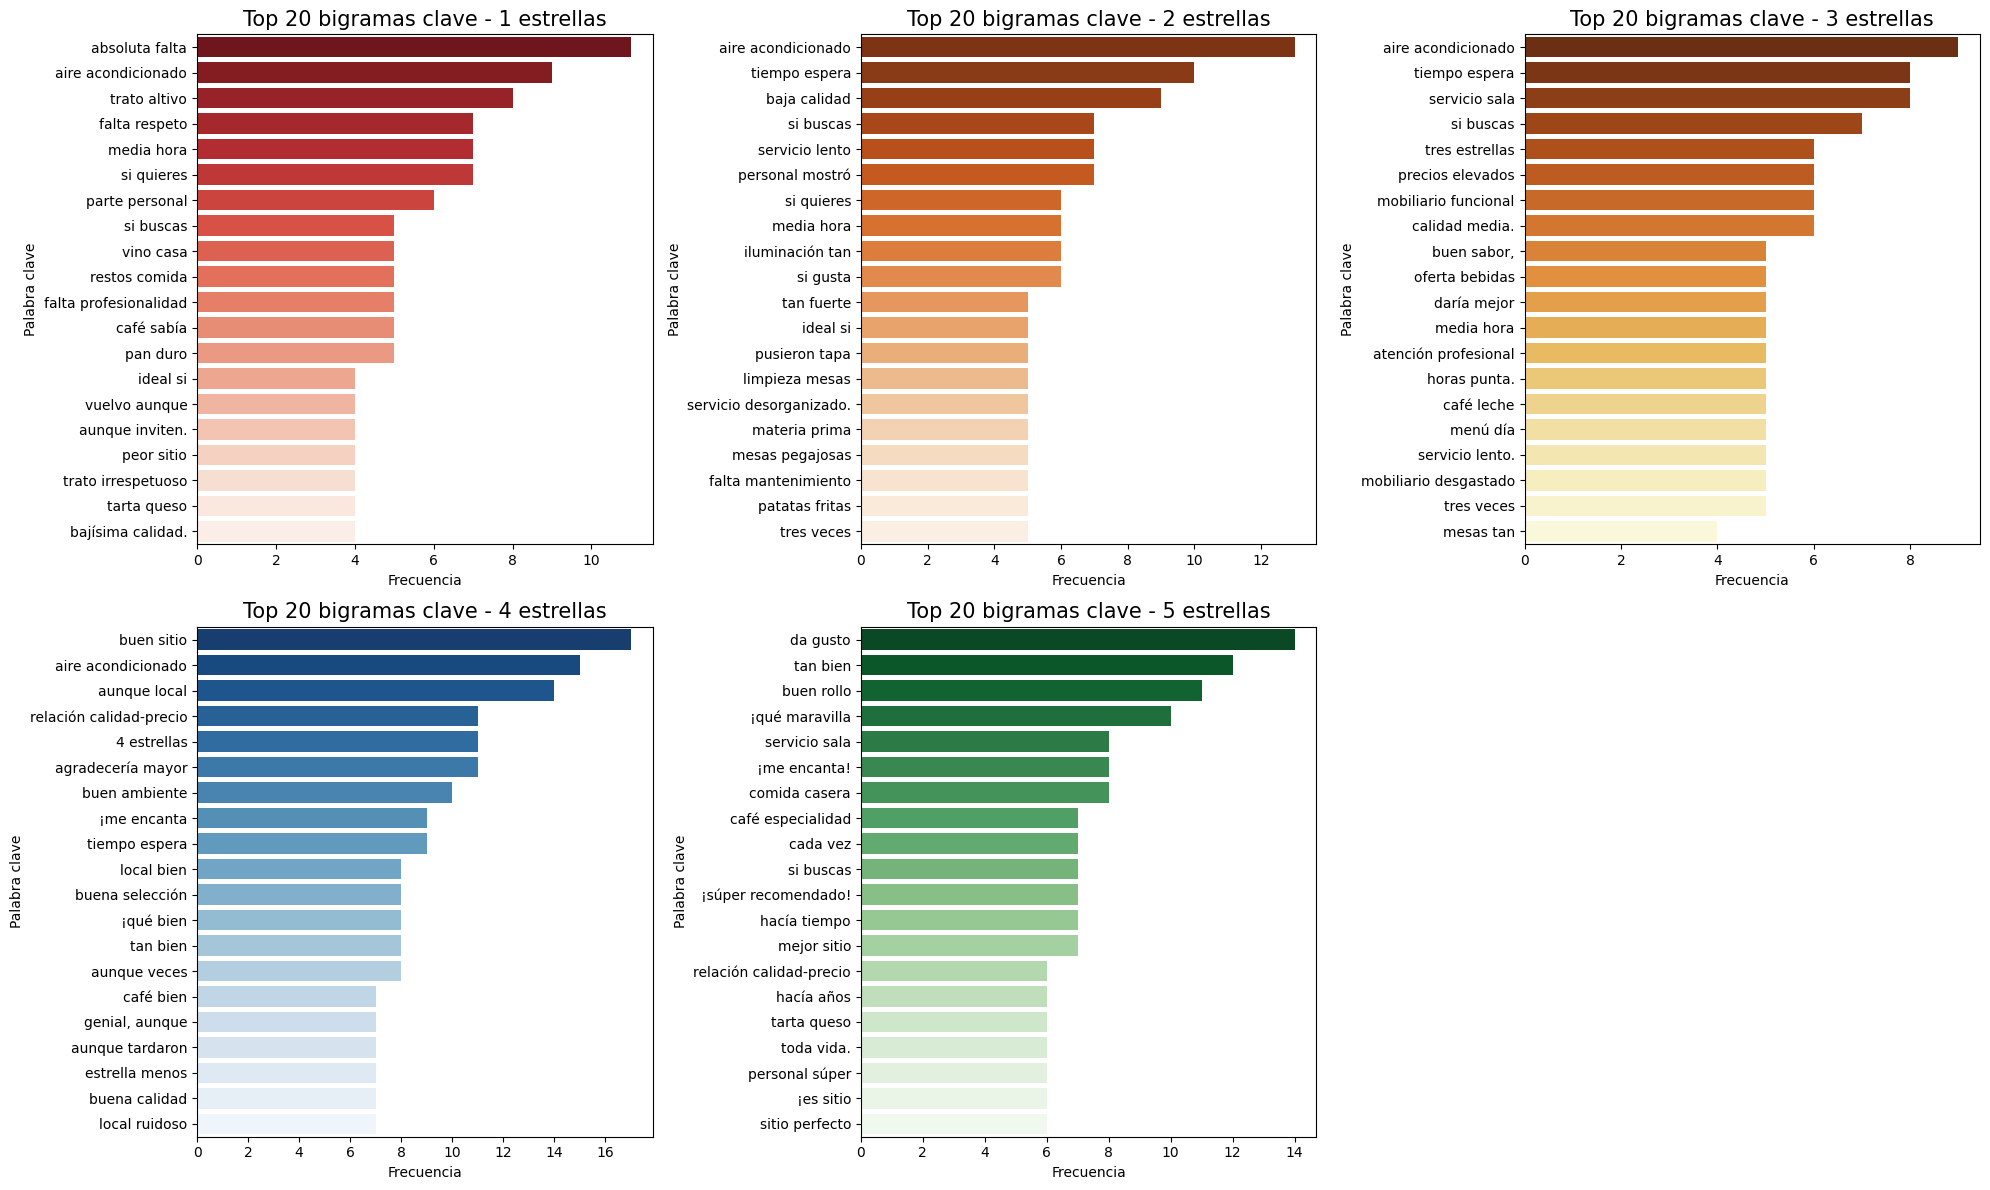

In [ ]:
dfs = []
titles = []
palettes = ['Reds_r', 'Oranges_r', 'YlOrBr_r', 'Blues_r', 'Greens_r']

for i in range(1,6):
  dfs.append(get_top_ngrams_by_stars(df, star_value = i))
  titles.append(f'Top 20 bigramas clave - {i} estrellas')

show_barplots(dfs, titles, palettes)

####4.3.4 Conclusión

A pesar de estar desvalanceado a favor de las puntuaciones más altas (5 y 4 estrellas) la valoración media es inferior a la real publicada en el 2024 por el estudio anteriormente mencionado.

Además, gracias a los gráficos mostrados podemos conocer y distinguir de forma más precisa las palabras y expresiones más comunes del dataset y cómo estas varían dependiendo del número de estrellas que se hayan fijado en las reseñas.

Las críticas más comunes van dirigidas al café, servicio, personal, limpieza y aire acondicionado. Mientras que en las reseñas mejor puntuadas se resalta la calidad del local y el ambiente. Otra diferencia muy notable es el uso de exclamaciones en las puntuaciones más altas para ensalzar sentimientos positivos.



###4.4 estilo

Característica fundamental del dataset. Permite generar textos más variados modificando su longitud, tono, vocabulario y expresiones.

Se han recogido los estilos más comunes que pueden encontrarse en reseñas reales:

1.   Entusiasta: Caracterizado por un alto grado de carga afectiva positiva. Utiliza de forma recurrente exclamaciones, adjetivos superlativos y un léxico que denota satisfacción máxima. El objetivo principal del autor es recomendar el establecimiento de forma apasionada.

2.   Crítico: Se centra exclusivamente en las deficiencias del producto o servicio, utilizando un lenguaje tajante para señalar errores específicos que afectaron la experiencia del usuario.

3.   Sarcástico: Empleo de la ironía y el. El autor suele afirmar lo contrario de lo que realmente siente o utiliza comparaciones exageradas, lo que supone un reto para el análisis de sentimiento tradicional.

4.   Breve: Reseñas caracterizadas por una mínima extensión semántica. Utilizan estructuras gramaticales simplificadas (a menudo sin verbos) y se limitan a dar una opinión directa en pocas palabras, sacrificando el contexto en favor de la rapidez.

5.   Constructivo: Aporta sugerencias específicas y razonadas para la mejora del negocio, manteniendo un tono de respeto y una voluntad de ayuda.

6.   Coloquial: Refleja el habla cotidiana e informal. Incluye jerga, expresiones regionales, abreviaturas y una sintaxis relajada. Busca generar cercanía y suele ser el estilo más común en plataformas de reseñas sociales.

7.   Anecdótico: El autor cuenta un suceso o historia específica ocurrida durante su visita, permitiendo que la evaluación del negocio se deduzca a través del relato de los hechos.

8.   Neutral: Se limita a constatar hechos y datos técnicos, su opinión no tiene apenas carga afectiva.

9.   Formal: Emplea un vocabulario preciso, fórmulas de cortesía y un tono profesional que mantiene la distancia entre el cliente y el personal del establecimiento.



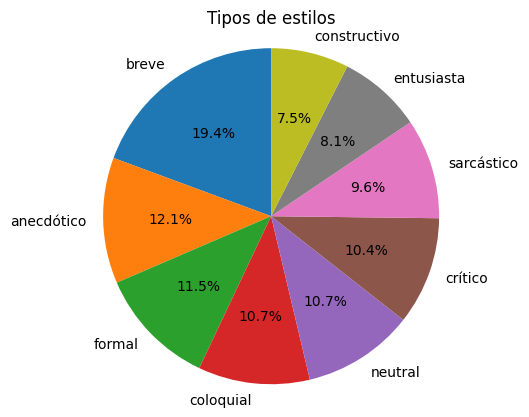

In [ ]:
labels = ['breve', 'anecdótico', 'formal', 'coloquial', 'neutral', 'crítico', 'sarcástico', 'entusiasta', 'constructivo']
counts = df['estilo'].value_counts()
sizes = []
for count_val in counts.values:
  size = (count_val / counts.sum())*100
  sizes.append(size)

plt.pie(sizes,
        labels = labels,
        autopct = '%1.1f%%',
        startangle = 90)
plt.axis('equal')
plt.title('Tipos de estilos')
plt.show()

####4.4.1 El sarcasmo en el análisis de sentimiento

* La mayoría de los modelos de clasificación de sentimiento asignan pesos positivos a palabras como "maravilloso" o "excelente". Y en una reseña sarcástica como "¡Maravilloso! tardadon solo una hora en traerme el café frío." el modelo detecta términos positivos cuando realmente se trata de una queja.

* El sarcasmo a menudo depende de hechos del mundo real que no están presentes en el texto. ¿Puede un modelo de lenguaje inferir, a partir del contexto, que “el filete casi sale corriendo” implica que estaba crudo?

* También se debe tener en cuenta que muchos modelos se basan en la frecuencia de palabras. El sarcasmo utiliza las mismas palabras que una reseña de 5 estrellas para describir una experiencia decepcionante correspondiente a 1 estrella. Esto puede generar muchos falsos positivos.

##5. Otros datos de interés

Número de reseñas generadas:

In [ ]:
df.shape[0]

5716

El conjunto de datos está completo, sin valores nulos:

In [ ]:
df.isna().sum()

,0
negocio,0
texto,0
estrellas,0
estilo,0


Sin elementos duplicados:

In [ ]:
df.duplicated().sum()

np.int64(0)

## 6. Ejemplos

In [ ]:
print("\n" + "="*80)
print("             MUESTRA DE RESEÑAS POR NÚMERO DE ESTRELLAS Y ESTILO")
print("="*80)

for i in range(1, 6):
  print(f"> {i} estrellas, {df[df['estrellas'] == i]['estilo'].iloc[i]}:\n",
        df[df['estrellas'] == i]['texto'].iloc[i], "\n")


             MUESTRA DE RESEÑAS POR NÚMERO DE ESTRELLAS Y ESTILO
> 1 estrellas, formal:
 Nula disposición para adaptar el menú a restricciones dietéticas comunicadas previamente. 

> 2 estrellas, constructivo:
 Tardan una eternidad en traer la cuenta. Un sistema más ágil de cobro haría que la rotación de mesas fuera mejor para ellos. 

> 3 estrellas, crítico:
 El sitio no está mal para una caña rápida, pero el servicio es tan lento que se te quitan las ganas de pedir la segunda. 

> 4 estrellas, neutral:
 Los vasos de agua se sirven por cortesía si el cliente lo solicita tras el café. 

> 5 estrellas, coloquial:
 El cordero está de muerte, se deshace en la boca. ¡Un auténtico espectáculo! 



##7. Bibliografía

https://www.ivie.es/es_ES/espana-la-primera-potencia-del-sector-la-restauracion-la-ue-27-una-aportacion-al-pib-unos-67-000-millones-euros-14-millones-empleados/

https://viajes.nationalgeographic.com.es/a/segunda-ciudad-mas-bares-espana-tambien-esta-castilla-leon_21819

https://superpopi.com/segundo-informe-de-rese%C3%B1as-google-en-restaurantes-de-espa%C3%B1a